# Mini Doctor AI
SymDesc2Diagnosis

- Symptoms described in natural language to be transformed to Diagnosis and Recommendations
- Askhat Aubakirov
- askhat.aub.work@gmail.com
- https://www.linkedin.com/in/askhattio/
- 2024

OUTLINE FOR THE PROJECT:
1) get data & perform EDA
2) clean up & do NLP augmentation -> perform second EDA to make sure additional data is out there 
3) perform feature engineering:
- lemmatize&tokenize
- create a matrix of features (save columns from train data for later) 
4) train the classification model
5) process the test data:
- split the data from target
- lemmatize and tokenize
- get rid of the mismatching features and fill them with zeroes
- perform testing
6) evaluate it (F1, precision, recall, ROC AUC)
7) wrap it up as a streamlit app

HOW IT SHOULD LOOK FOR THE USER:
- user goes to a website with the streamlit app hosted
- writes smth like "Oh I have a headache, yesterday I had a walk in the park and it was a little cold ..."
- gets the answer (diagnosis prediction) from the app
- gets a generated set of recommendations like "go ask a real doctor for help" or "It is highly recommended to avoid dehydration, get some ..."

# Imports

In [4]:
import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("import done")


/home/askhattio/ds/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


import done


In [5]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/askhattio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/askhattio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# EDA

In [3]:
data = pd.read_csv('data/data_no_dg.csv')
print(f"data shape is {data.shape}")
data.head()

data shape is (4905, 2)


,diseases,symptoms
0,Psoriasis,"The skin around my mouth, nose, and eyes is re..."
1,Psoriasis,The rash on my skin is worse in the winter mon...
2,Psoriasis,The skin on my palms and soles is thickened an...
3,Psoriasis,I have noticed a sudden peeling of skin at dif...
4,Psoriasis,I am starting to have rashes on my skin. The r...


diseases
Other classes                           2331
Malaria                                  101
Arthritis                                 52
Asthma                                    52
Stroke                                    52
Migraine                                  52
Psoriasis                                 52
Cholera                                   51
Breast Cancer                             51
Diabetes                                  51
Dengue Fever                              51
Acne                                      51
Pneumonia                                 51
Leukemia                                  51
Cervical spondylosis                      51
Jaundice                                  51
Impetigo                                  51
Hepatitis                                 51
Atherosclerosis                           51
HIV/AIDS                                  51
Varicose Veins                            51
Influenza (Flu)                           51
A

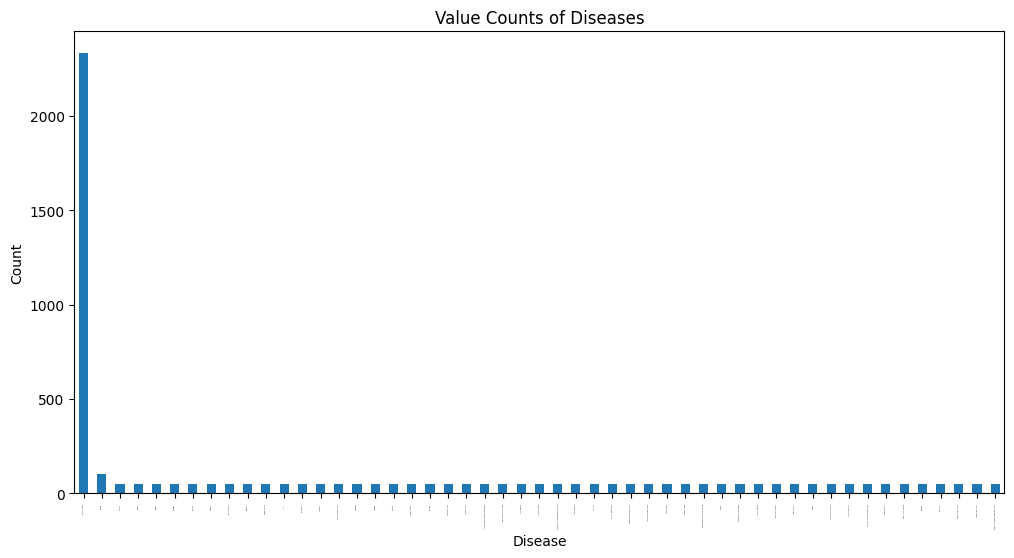

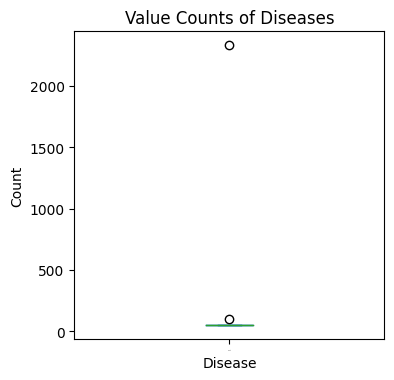

In [4]:
#takes ~13s to finish
disease_counts = data["diseases"].value_counts() #-> so we have 2161 disease in the dataset,
                                #some of them are with one mention only
                                #so they are not quite supported by data
                                #we should do augmentation (thanks to Artem for the idea)

print(disease_counts)

plt.figure(figsize=(12, 6))
disease_counts.plot(kind='bar')
plt.title('Value Counts of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(fontsize=1) #decrease fontsize for readability - unfortunately, readablity is close to zero
plt.show()

plt.figure(figsize=(4, 4))
disease_counts.plot(kind='box')
plt.title('Value Counts of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(fontsize=1)
plt.show()

In [5]:
#Exclusive for attempt #4 for SVM model -> drop "Other classes"
temp_df = data[data["diseases"] != "Other classes"]
print(temp_df.shape)

data = temp_df

data.to_csv("data/v4_SVM/data_no_others.csv", index=False)

data.head()

(2574, 2)


,diseases,symptoms
0,Psoriasis,"The skin around my mouth, nose, and eyes is re..."
1,Psoriasis,The rash on my skin is worse in the winter mon...
2,Psoriasis,The skin on my palms and soles is thickened an...
3,Psoriasis,I have noticed a sudden peeling of skin at dif...
4,Psoriasis,I am starting to have rashes on my skin. The r...


diseases
Malaria                                 101
Psoriasis                                52
Asthma                                   52
Stroke                                   52
Arthritis                                52
Migraine                                 52
Jaundice                                 51
Leukemia                                 51
Breast Cancer                            51
Atherosclerosis                          51
Dengue Fever                             51
Cholera                                  51
Hepatitis                                51
HIV/AIDS                                 51
Varicose Veins                           51
Influenza (Flu)                          51
Diabetes                                 51
Cervical spondylosis                     51
Acne                                     51
Pneumonia                                51
Impetigo                                 51
Fungal infection                         50
Interstitial Lung Disea

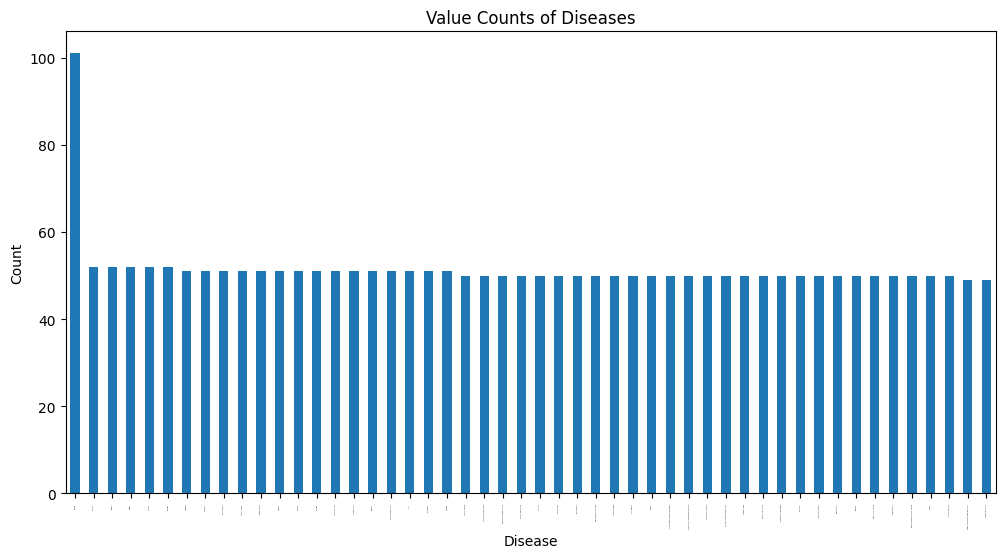

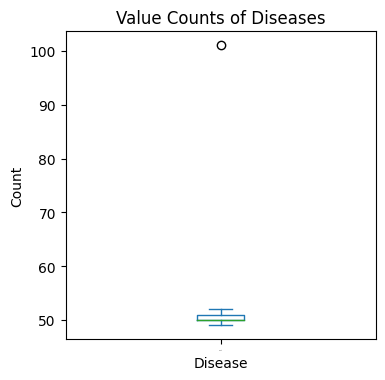

In [6]:
#takes ~13s to finish
disease_counts = data["diseases"].value_counts() #-> so we have 2161 disease in the dataset,
                                #some of them are with one mention only
                                #so they are not quite supported by data
                                #we should do augmentation (thanks to Artem for the idea)

print(disease_counts)

plt.figure(figsize=(12, 6))
disease_counts.plot(kind='bar')
plt.title('Value Counts of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(fontsize=1) #decrease fontsize for readability - unfortunately, readablity is close to zero
plt.show()

plt.figure(figsize=(4, 4))
disease_counts.plot(kind='box')
plt.title('Value Counts of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(fontsize=1)
plt.show()

# Feature Engineering
- tokenizing
- vectorizing data

## Engineering for train data

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
def tokenize_and_lemmatize(text):
  """
  Tokenizes and lemmatizes the input text.

  Args:
      text: A string representing the input text.

  Returns:
      a list of lemmas
  """
  lemmas = []
  
  doc = nlp(text)

  for token in doc:
      if token.is_alpha and not token.is_stop:
          lemmas.append(token.lemma_)
          new_lemma_tokens = " ".join(lemmas)

  return new_lemma_tokens

In [9]:
#takes 12 min to run
#zip() to unpack lists returned by tokenize_and_lemmatize
#data_lemmatized['lemmas'] = zip(*data['symptoms'].apply(tokenize_and_lemmatize))
data['lemmas'] = data['symptoms'].apply(tokenize_and_lemmatize)

In [10]:
data.to_csv("data/v4_SVM/data_lemmatized.csv", index=False)

In [11]:
data = pd.read_csv("data/v4_SVM/data_lemmatized.csv")

In [12]:
data.head()

,diseases,symptoms,lemmas
0,Psoriasis,"The skin around my mouth, nose, and eyes is re...",skin mouth nose eye red inflame itchy uncomfor...
1,Psoriasis,The rash on my skin is worse in the winter mon...,rash skin bad winter month air dry find moistu...
2,Psoriasis,The skin on my palms and soles is thickened an...,skin palm sol thicken deep crack crack painful...
3,Psoriasis,I have noticed a sudden peeling of skin at dif...,notice sudden peeling skin different part body...
4,Psoriasis,I am starting to have rashes on my skin. The r...,start rash skin rash bleed scratch rub notice ...


In [13]:
print(type(data["lemmas"]))
print(data["lemmas"])

<class 'pandas.core.series.Series'>
0       skin mouth nose eye red inflame itchy uncomfor...
1       rash skin bad winter month air dry find moistu...
2       skin palm sol thicken deep crack crack painful...
3       notice sudden peeling skin different part body...
4       start rash skin rash bleed scratch rub notice ...
                              ...                        
2569    jaundice appear suddenly develop slowly time s...
2570    symptom include Anemia condition body healthy ...
2571    main type migraine Migraine aura classic migra...
2572    psoriasis appear suddenly slowly time go away ...
2573    symptom stroke depend brain damage case person...
Name: lemmas, Length: 2574, dtype: object


In [14]:
#vectorizing the lemmatized text
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2))
X1 = vectorizer.fit_transform(data['lemmas'])
X1 = pd.DataFrame(X1.toarray(), columns=vectorizer.get_feature_names_out())
print(X1.shape)

(2574, 10000)


In [15]:
X1.to_csv("data/v4_SVM/X1_data_vectorized.csv", index=False)
X1

,AIDS,AIDS cause,AIDS high,AIDS immune,AIDS include,AIDS stage,AIDS year,Abdominal,Abdominal Discomfort,Abdominal Pain,...,yellow skin,yellow urine,yellow white,yellowish,yesterday,yesterday face,yesterday notice,yesterday severe,zigzag,zigzag line
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077018,0.0,0.08676,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.060617,0.060617
2572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [16]:
X1 = pd.read_csv("data/v4_SVM/X1_data_vectorized.csv")

In [17]:
#just checking the presence of some two worded symptoms
if "skin rash" in X1.columns: print("yes")

yes


In [18]:
X = X1
y = data["diseases"]

print(X.shape)
print(y.shape)

(2574, 10000)
(2574,)


# Model Training
code before was writen in local notebook, then continued in Google Colab, since I had some problems with NVIDIA card on a new linux distro (some stuff with kernel incompatibility - gotta solve it later >>> UPD: solution is to buy a new GPU, so not now)

## train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
#saving the train and test data in case I lose my session
X_train.to_csv("data/v4_SVM/X_train.csv", index=False)
X_test.to_csv("data/v4_SVM/X_test.csv", index=False)
y_train.to_csv("data/v4_SVM/y_train.csv", index=False)
y_test.to_csv("data/v4_SVM/y_test.csv", index=False)

In [6]:
X_train = pd.read_csv("data/v4_SVM/X_train.csv")
X_test = pd.read_csv("data/v4_SVM/X_test.csv")
y_train = pd.read_csv("data/v4_SVM/y_train.csv")
y_test = pd.read_csv("data/v4_SVM/y_test.csv")

## Random Forest

In [7]:
random_forest_classifier= RandomForestClassifier(random_state=42)
model_random_f = random_forest_classifier.fit(X_train,y_train) #training on data and answers

/home/askhattio/ds/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [12]:
joblib.dump(model_random_f, 'random_forest_model.joblib')

['random_forest_model.joblib']

# Testing the model

## Loading model

In [8]:
#svm_model = joblib.load('linear_svm_model.joblib') #THIS MODEL SHOWED 0.0012 accuracy -> sounds like a fail
#svm_model = joblib.load('v2_rbf_svm_model.joblib') #trying this one as the second attempt
svm_model = joblib.load('random_forest_model.joblib')

## Formatting the test data to fit the columns of train data
this is to be done with user input in Streamlit app

## Prediction & Metrics

In [17]:
train_predicted_random_f = model_random_f.predict(X_train)
test_predicted_random_f = model_random_f.predict(X_test)

In [18]:
print(train_predicted_random_f)

unique_elements = list(set(train_predicted_random_f))
print(unique_elements)
print(f"Length is {len(unique_elements)}")

['Asthma' 'Prostate Cancer' 'Pneumonia' ... 'HIV/AIDS' 'COVID-19.'
 'Jaundice']
['urinary tract infection', 'Asthma', 'diabetes', 'Hypertension', 'Skin Cancer (Melanoma)', 'Ebola Virus Disease', 'Impetigo', 'Jaundice', 'Diabetes', 'Chicken pox', 'Cholera', 'Psoriasis', 'Arrhythmias (Irregular Heartbeat)', 'Coronary Artery Disease (CAD)', 'Breast Cancer', 'Arthritis', 'Migraine', 'Bronchial Asthma', 'Prostate Cancer', 'HIV/AIDS', 'Hypertension (High Blood Pressure)', 'Chronic Obstructive', 'Pulmonary Disease (COPD)', 'Influenza (Flu)', 'peptic ulcer disease', 'Brain Cancer', 'gastroesophageal reflux disease', 'Atherosclerosis', 'Varicose Veins', 'drug reaction', 'Hepatitis', 'Dimorphic Hemorrhoids', 'allergy', 'Tuberculosis (TB)', 'Dengue Fever', 'Interstitial Lung Disease', 'Dengue', 'Cervical spondylosis', 'Colorectal Cancer', 'Heart Attack (Myocardial Infarction)', 'Malaria', 'Stroke', 'Typhoid', 'Pneumonia', 'Lung Cancer', 'COVID-19.', 'Acne', 'Fungal infection', 'Leukemia', 'Common

In [19]:
# Accuracy
accuracy = accuracy_score(y_test, test_predicted_random_f)
print("Accuracy:", accuracy)

Accuracy: 0.9281553398058252


In [21]:
# Precision, Recall, F1 Score -> using weighted average since the classes are imbalanced
precision = precision_score(y_test, test_predicted_random_f, average="weighted")
recall = recall_score(y_test, test_predicted_random_f, average="weighted")
f1 = f1_score(y_test, test_predicted_random_f, average="weighted")

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9334742388140447
Recall: 0.9281553398058252
F1 Score: 0.9279801277937362


In [22]:
conf_matrix = confusion_matrix(y_test, test_predicted_random_f)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 10]]


## Testing hypothetical input
for streamlit side

In [24]:
def tokenize_and_lemmatize(text):
  """
  Tokenizes and lemmatizes the input text.

  Args:
      text: A string representing the input text.

  Returns:
      a list of lemmas
  """
  lemmas = []
  
  doc = nlp(text)

  for token in doc:
      if token.is_alpha and not token.is_stop:
          lemmas.append(token.lemma_)
          new_lemma_tokens = " ".join(lemmas)

  return new_lemma_tokens

nlp = spacy.load('en_core_web_sm')
X_train = pd.read_csv("data/v4_SVM/X_train.csv")


svm_model = joblib.load('random_forest_model.joblib')

user_input = "The skin around my mouth, nose, and eyes is red and inflamed. It is often itchy and uncomfortable. There is a noticeable inflammation in my nails."
user_input = user_input.lower()

#vectorizing the lemmatized text
user_input = tokenize_and_lemmatize(user_input)
print(user_input)

vectorizer = TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2))
vectorized_input = vectorizer.fit_transform([user_input])
vectorized_input = pd.DataFrame(vectorized_input.toarray(), columns=vectorizer.get_feature_names_out())

print(vectorized_input.head(1))

#finding the missing columns in the test dataframe
#filling missing columns with zeros -> they don't exist in the train dataframe
missing_columns = set(X_train.columns) - set(vectorized_input.columns)
for col in missing_columns:
    vectorized_input[col] = 0

vectorized_input = vectorized_input[X_train.columns]
print(vectorized_input.head(1))

#predicting
y_pred_input = svm_model.predict(vectorized_input)
print(f"Prediction for the user input is {y_pred_input}")

skin mouth nose eye red inflame itchy uncomfortable noticeable inflammation nail
        eye   eye red   inflame  inflame itchy  inflammation  \
0  0.218218  0.218218  0.218218       0.218218      0.218218   

   inflammation nail     itchy  itchy uncomfortable     mouth  mouth nose  \
0           0.218218  0.218218             0.218218  0.218218    0.218218   

   ...      nose  nose eye  noticeable  noticeable inflammation       red  \
0  ...  0.218218  0.218218    0.218218                 0.218218  0.218218   

   red inflame      skin  skin mouth  uncomfortable  uncomfortable noticeable  
0     0.218218  0.218218    0.218218       0.218218                  0.218218  

[1 rows x 21 columns]


/tmp/ipykernel_11485/917291240.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_input[col] = 0
/tmp/ipykernel_11485/917291240.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_input[col] = 0
/tmp/ipykernel_11485/917291240.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

   AIDS  AIDS cause  AIDS high  AIDS immune  AIDS include  AIDS stage  \
0     0           0          0            0             0           0   

   AIDS year  Abdominal  Abdominal Discomfort  Abdominal Pain  ...  \
0          0          0                     0               0  ...   

   yellow skin  yellow urine  yellow white  yellowish  yesterday  \
0            0             0             0          0          0   

   yesterday face  yesterday notice  yesterday severe  zigzag  zigzag line  
0               0                 0                 0       0            0  

[1 rows x 10000 columns]
Prediction for the user input is ['Psoriasis']
